## Import required libraries

In [13]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

## Input scan folder

In [14]:
#proposal = '20250420' # Only needed when working on MAXIV cloud
#visit = '2025090908' # Only needed when working on MAXIV cloud
scan ='62739'
DataFolder = f'Data/{scan}_rebinned'


if os.path.isdir(DataFolder):
    print(f'Folder exists:{DataFolder}')
    num_files= len([f for f in os.listdir(DataFolder)])
    print(f'Number of files: {num_files}')
else:
    print('Folder does not exist')


Folder exists:Data/62739_rebinned
Number of files: 1662


## Plot intensity vs. elution time

Choose to sum or average over a certain q range

%matplotlib inline  Default non-interactive plot

%matplotlib widget  Interactive plot, requires 'ipympl' package to be installed

In [26]:
%matplotlib widget
import matplotlib.pyplot as plt

# q-range for summing/averaging - accepts multiple ranges as tuples
q_min = (0.01,0.05)
q_max = (0.08,0.07)

intensity_list = {}
# Plot sum of intensity
for qmin, qmax in zip(q_min, q_max):
    intensities = []
    for frame in range(num_files): # For every shot/file in the folder
        data = np.loadtxt(f'{DataFolder}/shot_{frame:04d}_rebinned.dat', skiprows=1)   # Change this to the format of your data files, mine has the detector name after the shot number
        dataq = data[:,0]
        dataI = data[:,1]
        mask = (dataq <= qmax) & (dataq >= qmin) # Mask for the desired q-range
        avg_intensity = np.sum(dataI[mask])/len(data[:,0])
        #sum_intensity = np.sum(dataI[mask]) # Toggle to choose between sum or average
        intensities.append(avg_intensity)
        #intensities.append(sum_intensity)   # Toggle to choose between sum or average
    intensity_list[f'{qmin}_{qmax}'] = intensities

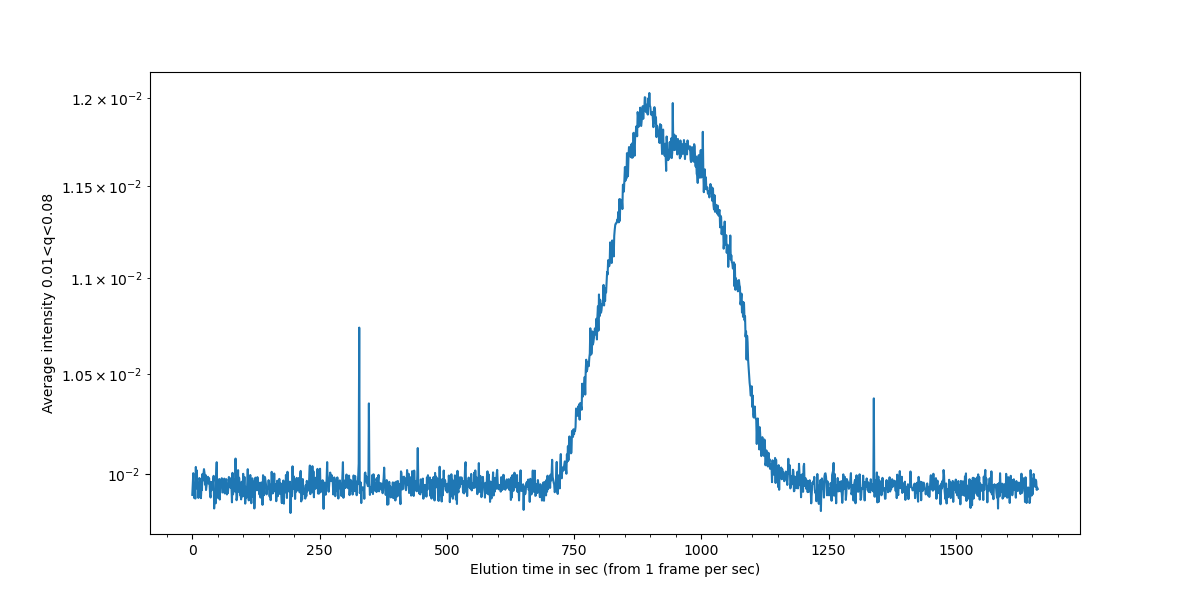

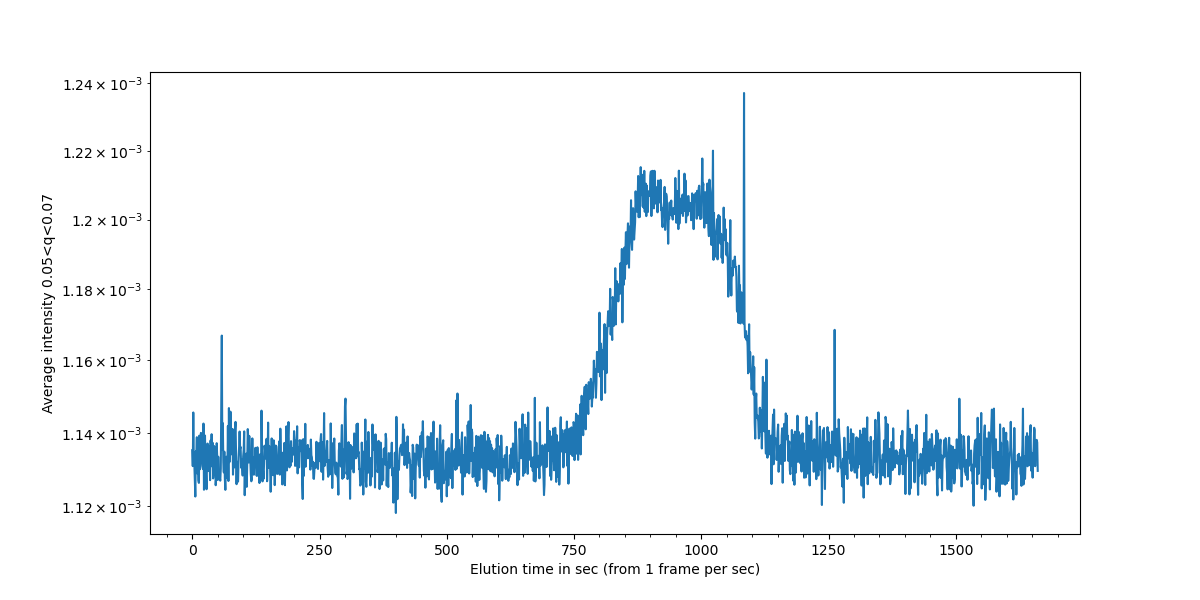

In [27]:
for qmin, qmax in zip(q_min, q_max):
    plt.figure(figsize=(12,6))
    plt.plot(range(num_files), intensity_list[f'{qmin}_{qmax}'])
    plt.yscale('log')
    plt.gca().minorticks_on()
    plt.xlabel('Elution time in sec (from 1 frame per sec)')
    plt.ylabel(f'Average intensity {qmin}<q<{qmax}')

## Save "chromatogram"

In [28]:
from functions import save_chromatogram

time = range(num_files)
for qmin, qmax in zip(q_min, q_max):
    key = f'{qmin}_{qmax}'
    if key not in intensity_list:
        print(f"Skipping save: no data for {key}")
        continue
    chromatogram = intensity_list[key]   # don't overwrite the dict
    save_chromatogram(scan, qmin, qmax, time, chromatogram)

Data saved for 62739 at output_chromatogram/62739_chromatogram_0.01_0.08.dat
Data saved for 62739 at output_chromatogram/62739_chromatogram_0.05_0.07.dat


## Merge frames and average intensity and error
Loops through all shots/frames in range using the logic:

for scan in range(start_frame, end_frame):

        data = np.genfromtxt(f'{DataFolder}/shot_{scan:04d}{filesuffix}.dat', skip_header=1)

Edit as needed in the functions.py file

merged / averaged I calculated by:
$$I_{merged} = \frac{\sum I}{number~of~frames}$$
$$Err_{merged}~or~\sigma= \frac{\sqrt{\sum \sigma^2}}{number~of~frames}$$

In [10]:
from functions import merge_frames

Buffer_start = 200
Buffer_end = 400  # First and last frame of buffer region (it will include the last frame since +1 is added in the function call)

Buffer_q, Buffer_I, Buffer_err, Buffer_count = merge_frames(DataFolder, '_rebinned', Buffer_start, Buffer_end+1)

print(f'Number of buffer frames merged: {Buffer_count}')

Number of buffer frames merged: 201


In [11]:
from functions import merge_frames

Sample_start = 850
Sample_end = 900   # First and last frame of sample region (it will include the last frame since +1 is added in the function call)
Sample_q, Sample_I, Sample_err, Sample_count = merge_frames(DataFolder, '_rebinned', Sample_start, Sample_end+1)

print(f'Number of sample frames merged: {Sample_count}')

Number of sample frames merged: 51


## Subtract solvent/buffer from sample

Calculated by:
$$ I_{sub} = I_{sample}-I_{buffer}$$
$$ Err_{sub} = \sqrt{\sigma_{sample}^2 + \sigma_{buffer}^2} $$

In [12]:
subtracted_q = Sample_q
subtracted_I = Sample_I - Buffer_I
subtracted_err = np.sqrt(Sample_err**2 + Buffer_err**2)

## Plot

Text(0, 0.5, 'I (1/cm)')

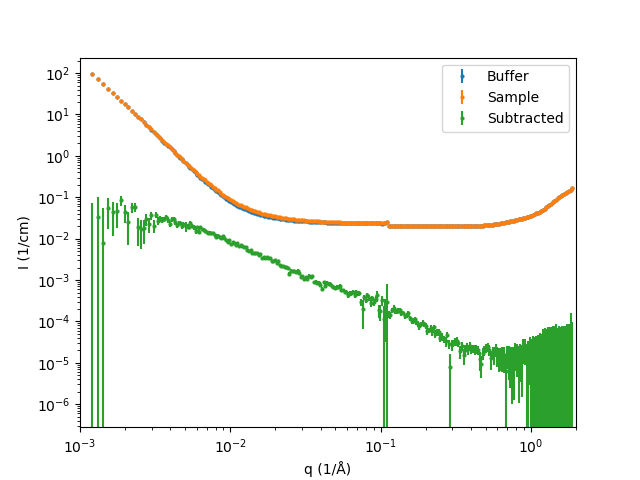

In [13]:
plt.figure()

plt.errorbar(Buffer_q, Buffer_I, yerr=Buffer_err, fmt='o', markersize=2, label='Buffer')
plt.errorbar(Sample_q, Sample_I, yerr=Sample_err, fmt='o', markersize=2, label='Sample')
plt.errorbar(subtracted_q, subtracted_I, yerr=subtracted_err, fmt='o', markersize=2, label='Subtracted')


plt.legend()
plt.xscale('log')
plt.xlim(1e-03, 2)
plt.yscale('log')
plt.xlabel('q (1/Å)')
plt.ylabel('I (1/cm)')

## Save data
def save_data (item_name, start_frame, end_frame, q_values, intensity_values, propagated_err):


In [14]:
from functions import save_data

save_data(scan ,'sample_1', Sample_start, Sample_end, Sample_q, Sample_I, Sample_err)
save_data(scan ,'buffer_1', Buffer_start, Buffer_end, Buffer_q, Buffer_I, Buffer_err)
save_data(scan ,'sample_1_subtracted_1', Sample_start, Sample_end, subtracted_q, subtracted_I, subtracted_err)

Data saved for sample_1 at shots 0850 to 0900 at Output/62743_sample_1_0850_0900.dat
Data saved for buffer_1 at shots 0200 to 0400 at Output/62743_buffer_1_0200_0400.dat
Data saved for sample_1_subtracted_1 at shots 0850 to 0900 at Output/62743_sample_1_subtracted_1_0850_0900.dat
